<a href="https://colab.research.google.com/github/mervenurerdogan/LungCancerTypePredict/blob/main/CancerTypeConvNext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq timm


In [2]:

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
import timm
from fastbook import *
from fastai.vision.all import *

In [4]:
all_convnext_models = timm.list_models('*convnext*')
all_convnext_models

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [5]:
path=Path('/content/gdrive/MyDrive/Data')


In [6]:
path.ls()


(#3) [Path('/content/gdrive/MyDrive/Data/test'),Path('/content/gdrive/MyDrive/Data/valid'),Path('/content/gdrive/MyDrive/Data/train')]

In [7]:
train_fnames=get_image_files(path/'train')
all_files=get_image_files(path)

In [8]:
tfms = aug_transforms(size=224, 
                      min_scale=0.75,
                      do_flip=True,
                      flip_vert=True,
                      max_rotate=360,
                      max_warp=0,
                      max_zoom=1.1,
                      max_lighting=0.1,
                      p_lighting=0.5
                      
                      
                      )

In [9]:
dblock=DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                 splitter=GrandparentSplitter(train_name='train',valid_name='valid'),
                 get_y=parent_label,
                 item_tfms=Resize(224,method='squish'),
                 batch_tfms=tfms
                 
                 
)

In [10]:
dls=dblock.dataloaders(all_files,bs=16)


In [11]:
train_df = len(train_fnames)
print(f"There are {train_df} images")

There are 613 images


In [12]:

valid_fnames=get_image_files(path/'valid')
valid_df = len(valid_fnames)
print(f"There are {valid_df} images")

There are 72 images


In [13]:

test_fnames=get_image_files(path/'test')
test_df = len(test_fnames)
print(f"There are {test_df} images")

There are 315 images


In [14]:
dls.c,len(dls.train_ds),len(dls.valid_ds)


(4, 613, 72)

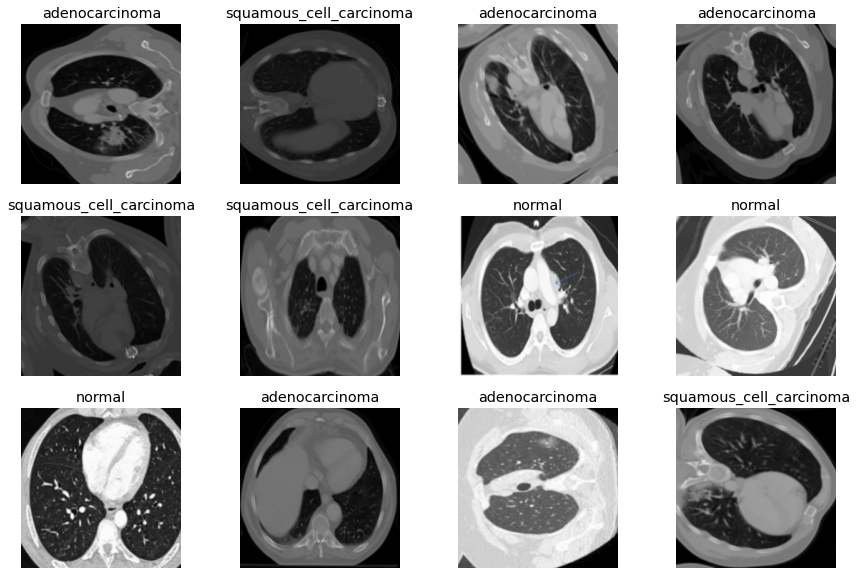

In [15]:
dls.show_batch(max_n=12,figsize=(15,10))


In [16]:
learn = vision_learner(dls,'convnext_tiny_in22k',  metrics=accuracy)


In [17]:
learn.summary()


Sequential (Input shape: 16 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 96 x 56 x 56   
Conv2d                                    4704       False     
LayerNorm2d                               192        True      
Identity                                                       
Conv2d                                    4800       False     
LayerNorm                                 192        True      
____________________________________________________________________________
                     16 x 56 x 56 x 384  
Linear                                    37248      False     
GELU                                                           
Dropout                                                        
____________________________________________________________________________
                     16 x 56 x 56 x 96   
Linear                                    36960      False     
Dropout                            

SuggestedLRs(valley=0.0008317637839354575)

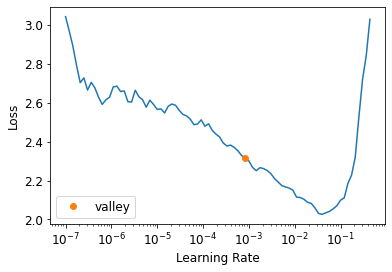

In [18]:
learn.lr_find()


In [19]:
learn.fine_tune(100,2.3e-3)


epoch,train_loss,valid_loss,accuracy,time
0,1.787895,1.720956,0.430556,00:10


epoch,train_loss,valid_loss,accuracy,time
0,1.300586,2.042322,0.361111,00:16
1,1.174773,2.239648,0.347222,00:17
2,1.011912,1.849533,0.361111,00:16
3,0.923822,1.643789,0.416667,00:17
4,0.855153,1.511658,0.458333,00:17
5,0.799360,1.386102,0.472222,00:17
6,0.746466,1.698368,0.416667,00:17
7,0.708646,1.562969,0.402778,00:16
8,0.681354,1.443811,0.472222,00:17
9,0.624030,1.592775,0.472222,00:16


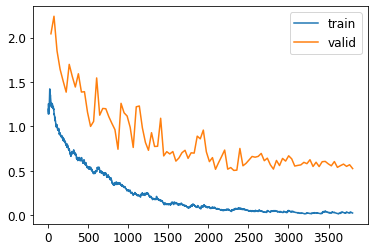

In [20]:
learn.recorder.plot_loss()


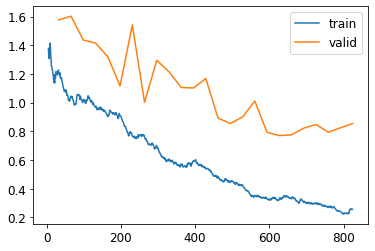

In [47]:
learn.recorder.plot_loss()


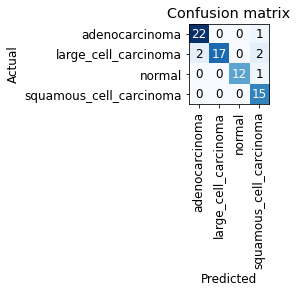

In [21]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [22]:
interp.print_classification_report()


                         precision    recall  f1-score   support

         adenocarcinoma       0.92      0.96      0.94        23
   large_cell_carcinoma       1.00      0.81      0.89        21
                 normal       1.00      0.92      0.96        13
squamous_cell_carcinoma       0.79      1.00      0.88        15

               accuracy                           0.92        72
              macro avg       0.93      0.92      0.92        72
           weighted avg       0.93      0.92      0.92        72



In [23]:

preds, targs = learn.tta()
accuracy(preds, targs).item()

0.9166666865348816

In [24]:
interp.most_confused()


[('large_cell_carcinoma', 'adenocarcinoma', 2),
 ('large_cell_carcinoma', 'squamous_cell_carcinoma', 2),
 ('adenocarcinoma', 'squamous_cell_carcinoma', 1),
 ('normal', 'squamous_cell_carcinoma', 1)]

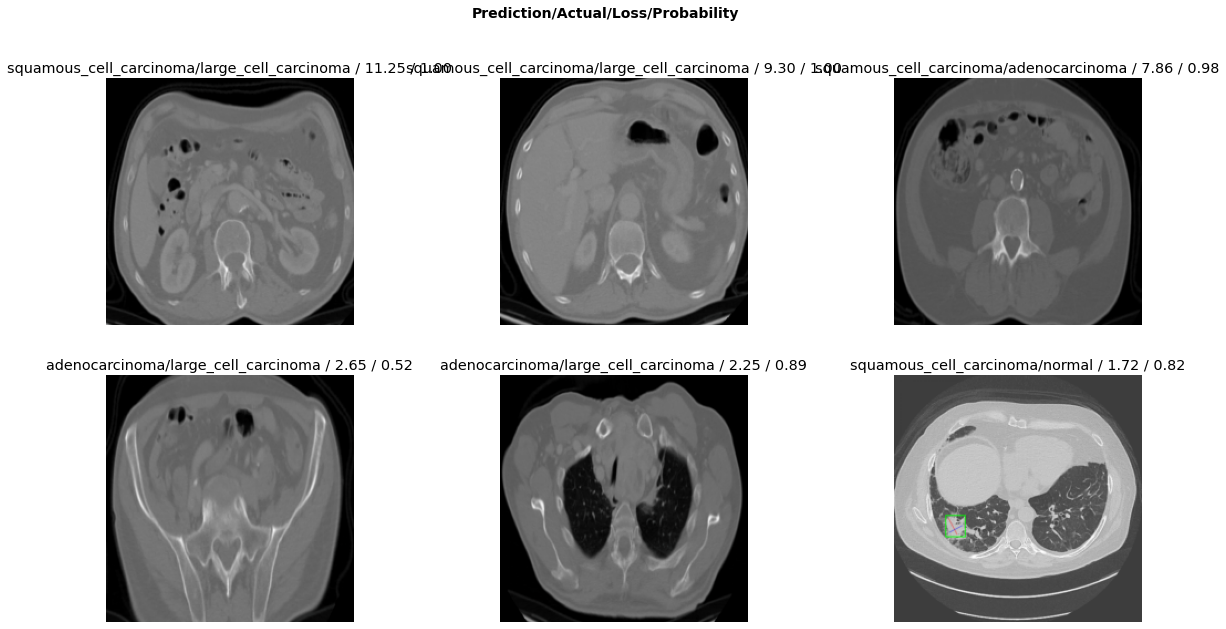

In [27]:
interp.plot_top_losses(6, figsize=(20,10))


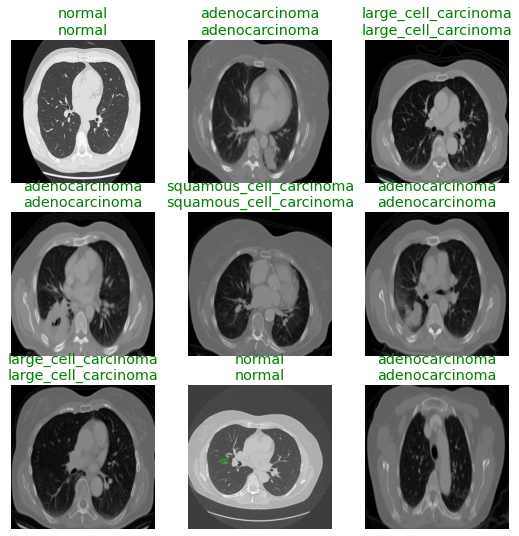

In [26]:
learn.show_results()


In [28]:
learn.save(path/'CA_Type__CovNext')


Path('/content/gdrive/MyDrive/Data/CA_Type__CovNext.pth')

In [29]:
learn.export(path/'CA_Type__CovNext_Exp.pkl')

In [30]:
dblock=DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                 splitter=GrandparentSplitter(train_name='train',valid_name='test'),
                 get_y=parent_label,
                 item_tfms=Resize(224,method='squish'),
                 batch_tfms=tfms
                 
                 
)

In [31]:
dls_test = dblock.dataloaders(all_files)


In [32]:
learn1= learn = vision_learner(dls_test,'convnext_tiny_in22k',  metrics=accuracy).load('/content/gdrive/MyDrive/Data/CA_Type__CovNext')


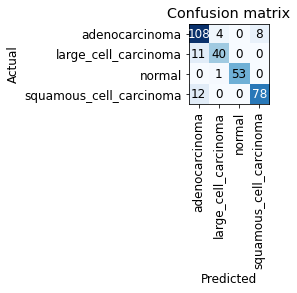

In [33]:

interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

In [34]:
interp.print_classification_report()


                         precision    recall  f1-score   support

         adenocarcinoma       0.82      0.90      0.86       120
   large_cell_carcinoma       0.89      0.78      0.83        51
                 normal       1.00      0.98      0.99        54
squamous_cell_carcinoma       0.91      0.87      0.89        90

               accuracy                           0.89       315
              macro avg       0.91      0.88      0.89       315
           weighted avg       0.89      0.89      0.89       315



In [35]:
preds, targs = learn1.tta()
accuracy(preds, targs).item()

0.920634925365448

In [36]:
interp.most_confused()


[('squamous_cell_carcinoma', 'adenocarcinoma', 12),
 ('large_cell_carcinoma', 'adenocarcinoma', 11),
 ('adenocarcinoma', 'squamous_cell_carcinoma', 8),
 ('adenocarcinoma', 'large_cell_carcinoma', 4),
 ('normal', 'large_cell_carcinoma', 1)]

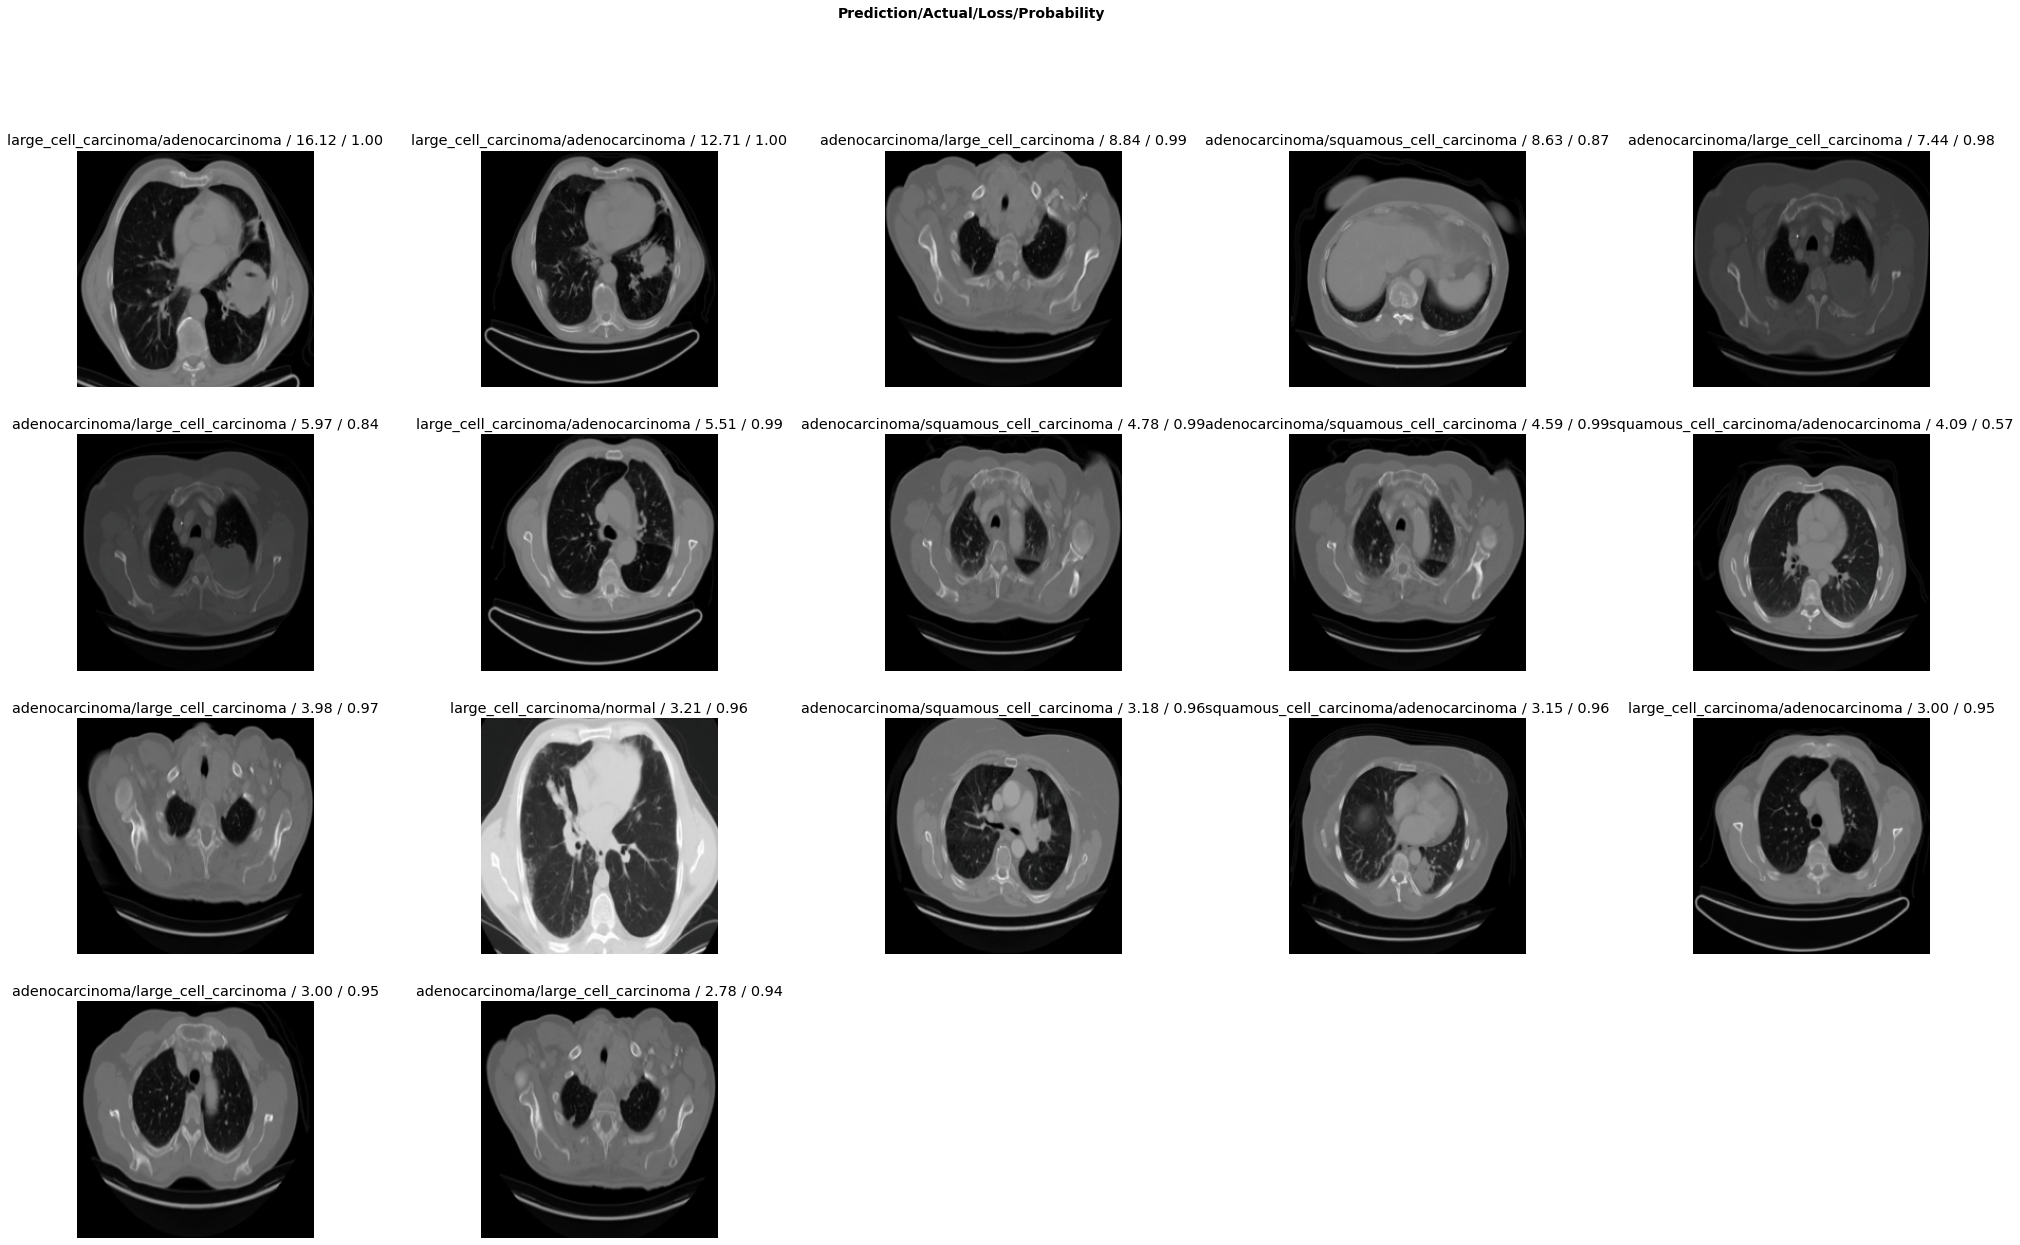

In [37]:
interp.plot_top_losses(17, figsize=(35,20))


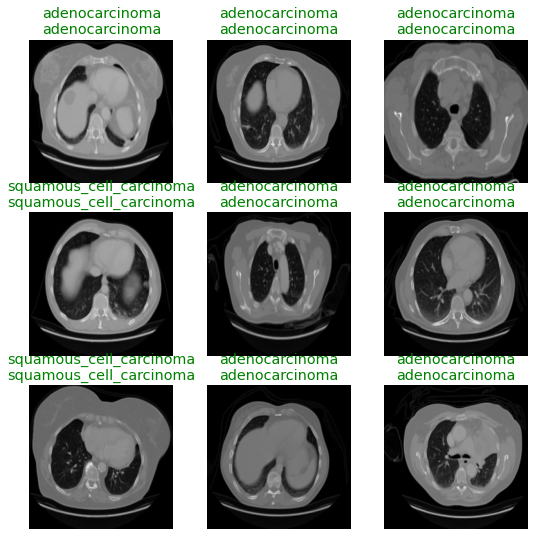

In [38]:
learn1.show_results()


In [39]:
losses,idxs = interp.top_losses(36)
print(idxs)

TensorBase([256, 247, 192, 108, 171, 189, 273,  73, 134, 296, 186,  47,  72, 244, 265, 167, 149, 283,  89, 132, 106, 100, 294, 179, 144, 176, 154, 130, 182,  76, 209, 234, 313,  62, 255, 269])


In [40]:
dls_test.valid_ds.items[256]


Path('/content/gdrive/MyDrive/Data/test/adenocarcinoma/000158 (3).png')

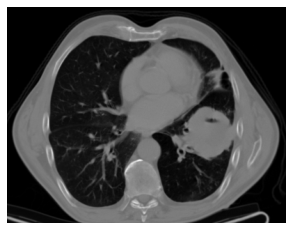

In [41]:
img = PILImage.create('/content/gdrive/MyDrive/Data/test/adenocarcinoma/000158 (3).png')
img.show()

In [42]:
class HookActivation():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_activation` function."""

        self.hook = target_layer.register_forward_hook(self.hook_activation) 
        
    def hook_activation(self, target_layer, activ_in, activ_out): 
        """Create a copy of the layer output activations and save 
        in `self.stored`.
        """
        self.stored = activ_out.detach().clone()
        
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()

        
class HookGradient():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_gradient` function."""
        
        self.hook = target_layer.register_backward_hook(self.hook_gradient)   
        
    def hook_gradient(self, target_layer, gradient_in, gradient_out): 
        """Create a copy of the layer output gradients and save 
        in `self.stored`.
        """
        self.stored = gradient_out[0].detach().clone()
        
    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()

In [43]:
m = learn1.model.eval();
m;

In [44]:
target_layer = learn1.model[0]

target_layer;

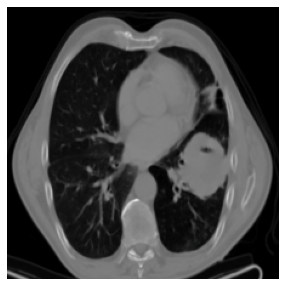

In [45]:

x, = first(dls_test.test_dl([img]))

x_img = TensorImage(dls_test.train.decode((x,))[0][0])
x_img.show()

In [46]:
learn1.predict(img)

('large_cell_carcinoma',
 TensorBase(1),
 TensorBase([1.0019e-07, 1.0000e+00, 4.9456e-09, 4.5823e-07]))